# Муравьиные алгоритмы для решения задачи коммивояжера
### Визуализация поиска решения и анализ качества алгоритма

Для построение графиков и анимаций будем использовать библиотеки `matplotlib` и `plotly.graph_objects`. 
Добавим все необходимые библиотеки.

In [1]:
import pandas as pd
import plotly.graph_objects as go
from matplotlib import pyplot as plt
import seaborn as sns
import copy

sns.set(style="darkgrid")

from algorithms.ant import AntColony
from tsp import TSP
from typing import List
import numpy as np

Создадим функцию для сохранения информации о городах для TSP из текстового файла в `DataFrame`

In [2]:
def get_cities_df(file_path: str):
    cities_df = pd.read_csv(file_path, sep=' ', header=None)
    cities_df.columns = ['name', 'x', 'y']
    return cities_df

In [3]:
file_path = 'tests/50cities_1.txt'
cities_df = get_cities_df(file_path)

Посмотрим на сохраненный нами тест для 50 городов.

In [4]:
cities_df.head(7)

name    x    y
0     1  230  166
1     2   92   66
2     3   39   47
3     4  218  207
4     5   64  197
5     6  133  130
6     7  238   91

Напишем функцию инициализации задачи коммивояжера

In [5]:
def init_tsp(cities_df: pd.DataFrame):
    cities: List[TSP.City] = []
    for _, row in cities_df.iterrows():
        id, x, y = row['name'], row['x'], row['y']
        cities.append(TSP.City(id, int(x), int(y)))
    return TSP(cities)

Теперь передадим задачу в муравьиный алгоритм и запустим ее

In [6]:
tsp = init_tsp(cities_df)

as_settings = AntColony.Settings(iterations=100)
as_colony = AntColony(AntColony.Variation.ANT_SYSTEM, as_settings)

In [7]:
%%time
dist = as_colony.solve(tsp, logging=True)

print("Ant System: ", dist)

Ant System:  2000.691514038075
CPU times: user 29.5 s, sys: 69.1 ms, total: 29.5 s
Wall time: 29.6 s


Реализуем функцию, которая будет рисовать график-анимацию нахождения решения

In [8]:
def plot_tsp(cities_df, tsp, title):
    points = go.Scatter(x=cities_df['x'], y=cities_df['y'], mode='markers',
                        marker=dict(color='#5D69B1', size=10), name='Город',
                        text = ["Название: {}".format(name) for name in cities_df['name'] ])

    paths_history, distances_history = tsp.get_solutions_history()
    answer = paths_history[-1]

    path = go.Scatter(x=answer[0], y=answer[1], mode='lines', name="Маршрут")

    button = {
            "type": "buttons",
            "buttons": [
                {
                    "label": "Запустить",
                    "method": "animate",
                    "args": [None, {"frame": {"duration": 180},
                                    "fromcurrent": True}],
                },
                {
                    "label": "Остановить",
                    "method": "animate",
                    "args": [[None], {"frame": {"duration": 0, "redraw": False},
                                      "mode": "immediate",
                                      "transition": {"duration": 0}}],
                }
            ],
        }

    frames = []
    for i in range(len(paths_history)):
        path = go.Scatter(x=paths_history[i][0], y=paths_history[i][1], mode='lines', name="Маршрут")
        layout = go.Layout(updatemenus=[button], 
                           title_text=f"Маршрут, найденный {title} за {i + 1} итераций, " +
                                      f"длина маршрута = {distances_history[i]}")
        frame = go.Frame(data=[points, path], layout=layout)
        frames.append(frame)


    fig = go.Figure(data=[points, path], frames=frames, layout=layout)
    fig.show()

In [9]:
plot_tsp(cities_df, tsp, "Ant System")

Так как шаг муравья выбирается случайным образом с учетом вероятности, то от запуска к запуску мы будем получать различные ответы. Поэтому сделаем функцию, которая будет запускать алгоритм несколько раз, чтобы учитывать случайность и приблизиться к наикротчайшему решению.

__Почему нельзя просто увеличить количество итераций?__
Потому что нам необходимо полностью обновить всю случайность алгоритма. При увеличении итераций феромон на ребрах графа продолжает изменяться и влияет на выбор муравьев. При полном перезапуске весь феромон очищается и, таким образом, муравьи начинают поиск без стимуляции, вызванной стигмергией.

In [10]:
def run(tsp: TSP, ant_colony: AntColony, attempts: int, logging=True):
    min_dist = float('inf')
    best_tsp = None
    
    for attempt in range(attempts):
        tsp.clear_answer()
        dist = ant_colony.solve(tsp, logging)
        if dist < min_dist:
            min_dist = dist
            if logging:
                best_tsp = copy.deepcopy(tsp)
    
    return best_tsp if logging else min_dist

Теперь мы можем собрать все в одну функцию, которая по пути к файлу будет строить график-анимацию. Более того, нами были реализованы различные модификации муравьиного алгоритма (помимо муравьиной системы "Ant System"), поэтому в функции мы будем принимать экземпляр класса `AntColony` с выставленными настройками, то есть с выбором модификации, и заданными параметрами.

In [11]:
def get_solution(file_path: str, ant_colony: AntColony, attempts=1, logging=True):
    cities_df = get_cities_df(file_path)
    tsp = init_tsp(cities_df)
    return cities_df, run(tsp, ant_colony, attempts, logging)

In [22]:
file_path = 'tests/16cities_1.txt'
iterations = 100
as_settings = AntColony.Settings(alpha=0.1, beta=3, rho=0.4, ants=15, iterations=iterations)
as_colony = AntColony(AntColony.Variation.ANT_SYSTEM, as_settings)

cities_df, tsp = get_solution(file_path, as_colony, 5)
plot_tsp(cities_df, tsp, 'Ant System')

Чтобы сохранять полученные графики, сделаем функцию, которая по имени будет подбирать порядковый номер так, чтобы старые картинки не перезатирались.

In [23]:
import os.path

def get_file_name(out_name):
    i = 1
    file_name = f"aco_results/{out_name}_{i}.svg"
    while os.path.exists(file_name):
        i += 1
        file_name = f"aco_results/{out_name}_{i}.svg"
    
    return file_name

In [24]:
get_file_name('convergence')

'aco_results/convergence_6.svg'

In [25]:
def plot_convergence(tsp, title, answer=0):
    plt.figure(figsize=(12, 6))
    grid = np.arange(1, iterations + 1)
    _, distances = tsp.get_solutions_history()
    plt.plot(grid, distances, color='blue', label='Найденный маршрут')
    
    if answer != 0:
        plt.plot(grid, np.full(iterations, answer), color='green', 
                 linestyle='--', linewidth=1, label='Кратчайший маршрут')
    
    plt.xlabel('Количество итераций', fontsize=13)
    plt.ylabel('Длина маршрута', fontsize=13)
    plt.title(f'Длина найденного маршрута алгоритмом {title}\n' + 'в зависимости от числа итераций', fontsize=16)
    plt.legend(loc=1)
    
    plt.savefig(get_file_name('convergence'))
    plt.show()

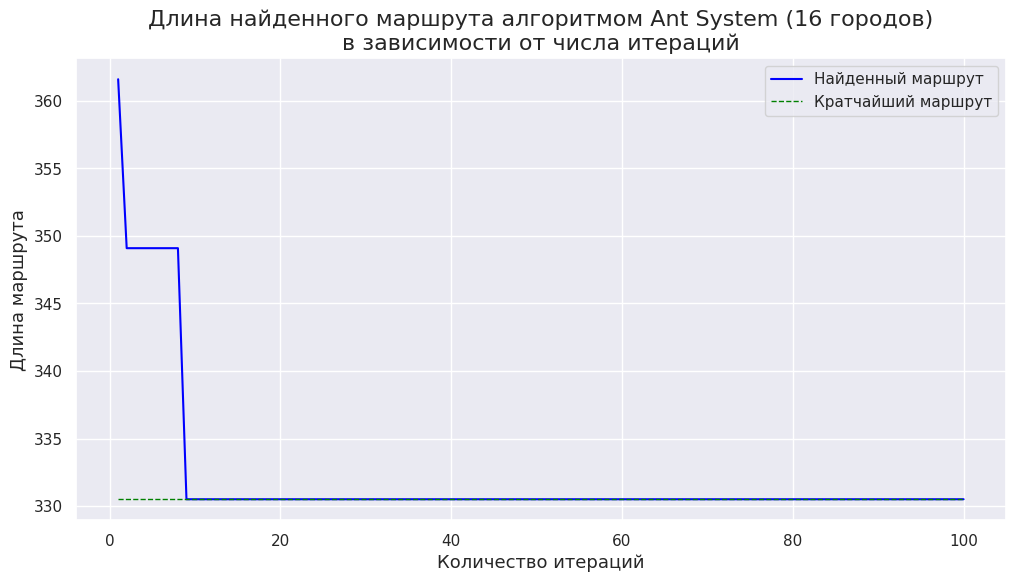

In [26]:
plot_convergence(tsp, 'Ant System (16 городов)', answer=330.5054664199449)

In [27]:
def plot_research(tsp, title, answer=0):
    plt.figure(figsize=(12, 6))
    grid = np.arange(1, iterations + 1)
    plt.plot(grid, tsp.get_iterations(), color='blue', linewidth=1, label='Наилучшее решение на каждой итерации')
    _, distances = tsp.get_solutions_history()
    plt.plot(grid, distances, color='red', label='Наилучшее решение с начала работы алгоритма')
    
    if answer != 0:
        plt.plot(grid, np.full(iterations, answer), color='green', 
                 linestyle='--', linewidth=1, label='Кратчайший маршрут')
    
    plt.xlabel('Номер итерации', fontsize=13)
    plt.ylabel('Длина маршрута', fontsize=13)
    plt.title(f'Исследование процесса решения алгоритмом {title}', fontsize=16)
    plt.legend(loc=1)
    
    plt.savefig(get_file_name('best_result'))
    plt.show()

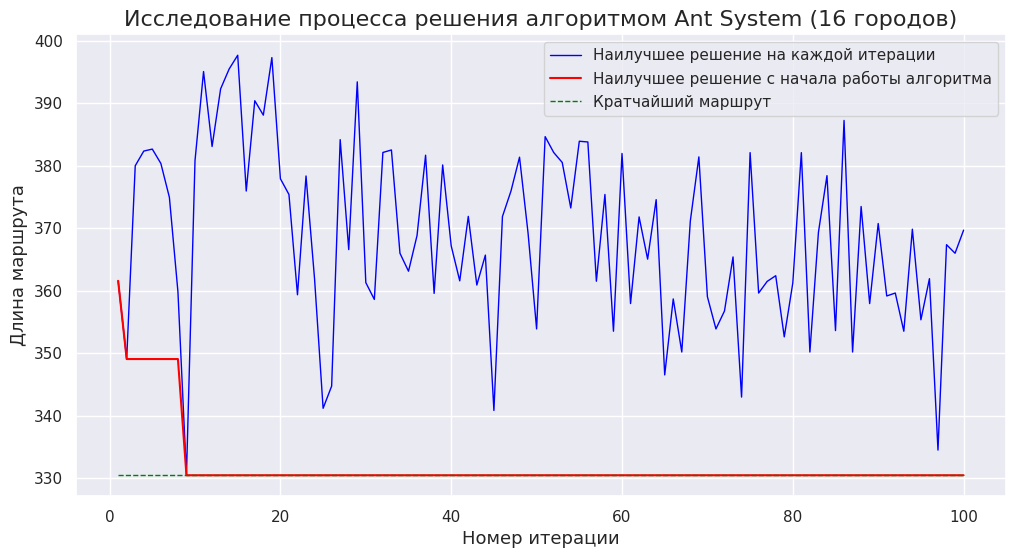

In [28]:
plot_research(tsp, 'Ant System (16 городов)', answer=330.5054664199449)

In [29]:
def plot_deviation(tsp, title):
    plt.figure(figsize=(12, 6))
    grid = np.arange(1, iterations + 1)
    rmse = tsp.get_ants_distances().std(axis=1)
    
    plt.plot(grid, rmse, color='blue', linewidth=1)
    
    plt.xlabel('Номер итерации', fontsize=13)
    plt.ylabel('Среднее квадратическое отклонение', fontsize=13)
    plt.title(f'Исследование RMSE решений по итерациям алгоритма {title}', fontsize=16)
    
    plt.savefig(get_file_name('deviation'))
    plt.show()

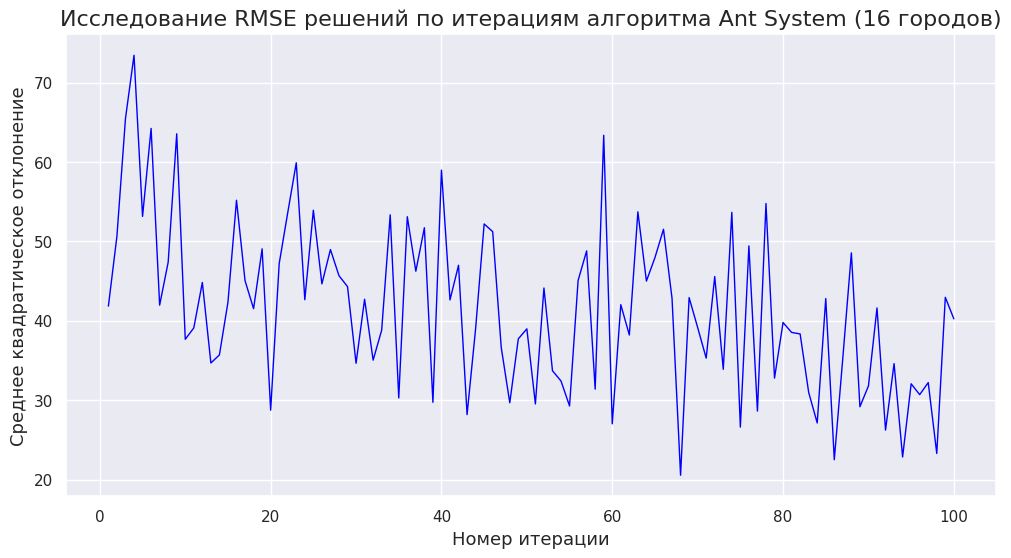

In [30]:
plot_deviation(tsp, 'Ant System (16 городов)')

Теперь займемся поиском оптимальных параметров. Для этого напишем поиск по сетке.

In [31]:
from typing import Iterable
from itertools import product

def grid_parameters(parameters: dict) -> Iterable:
    for params in product(*parameters.values()):
        yield dict(zip(parameters.keys(), params))

In [32]:
%%time
file_path = 'tests/16cities_1.txt'
params = {
    'ants': [10, 15, 16, 18],
    'alpha': [.1, .5, 1, 1.2],
    'beta': [2, 3, 4, 5],
    'rho': [.4, .5, .6],
    'iterations': [100]
}

best_settings = None
best_dist = float('inf')

for settings in grid_parameters(params):
    as_settings = AntColony.Settings(**settings)
    as_colony = AntColony(AntColony.Variation.ANT_SYSTEM, as_settings)
    _, dist = get_solution(file_path, as_colony, attempts=5, logging=False)
    if dist < best_dist:
        best_dist = dist
        best_settings = settings

print(f'Лучшее расстояние: {best_dist} с параметрами', best_settings)

Лучшее расстояние: 330.505466419945 с параметрами {'ants': 15, 'alpha': 0.1, 'beta': 3, 'rho': 0.4, 'iterations': 100}
CPU times: user 32min 5s, sys: 1.99 s, total: 32min 7s
Wall time: 32min 8s


Теперь исследуем разные значения каждого из параметров. При этом будем фиксировать остальные параметры оптимальным значением.

In [33]:
def plot_various_ants(file_path, title, iterations, ants, alpha, beta, rho, answer=0):
    plt.figure(figsize=(12, 6))
    grid = np.arange(1, iterations + 1)
    
    for ant in ants:
        as_settings = AntColony.Settings(alpha=alpha, beta=beta, rho=rho, ants=ant, iterations=iterations)
        as_colony = AntColony(AntColony.Variation.ANT_SYSTEM, as_settings)
        cities_df, tsp = get_solution(file_path, as_colony, 5)
        
        _, distances = tsp.get_solutions_history()
        plt.plot(grid, distances, label=f'{ant} муравьев')
        
    if answer != 0:
        plt.plot(grid, np.full(iterations, answer), color='green', 
                 linestyle='--', linewidth=1, label='Кратчайший маршрут')
    
    plt.xlabel('Количество итераций', fontsize=13)
    plt.ylabel('Длина маршрута', fontsize=13)
    plt.title(f'Длина найденного маршрута алгоритмом {title}\n' 
              + f'в зависимости от количества муравьев', fontsize=16)
    plt.legend(loc=1)
    
    plt.savefig(get_file_name('ants_number'))
    plt.show()

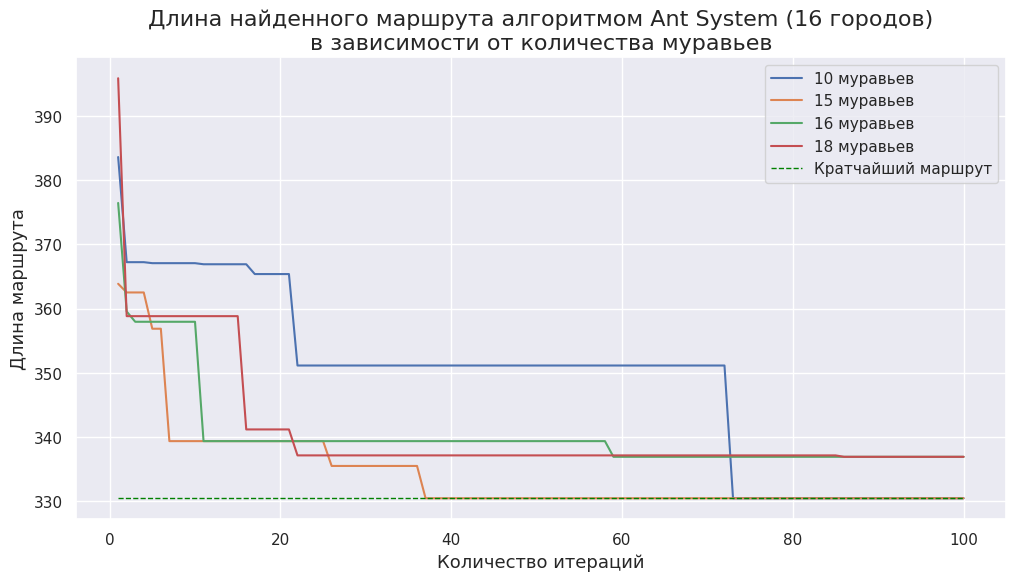

In [34]:
file_path = 'tests/16cities_1.txt'
ants = [10, 15, 16, 18]

plot_various_ants(file_path, 'Ant System (16 городов)', iterations=100, ants=ants, 
                  alpha=.1, beta=3, rho=.4, answer=330.5054664199449)

In [35]:
def plot_various_params(file_path, title, iterations, ants, params, answer=0):
    plt.figure(figsize=(12, 6))
    grid = np.arange(1, iterations + 1)
    
    alpha_len = len(params['alpha'])
    beta_len = len(params['beta'])
    rho_len = len(params['rho'])
    
    for i in range(max(alpha_len, beta_len, rho_len)):
        alpha = params['alpha'][i % alpha_len]
        beta = params['beta'][i % beta_len]
        rho = params['rho'][i % rho_len]
        as_settings = AntColony.Settings(alpha=alpha, beta=beta, rho=rho, ants=ants, iterations=iterations)
        as_colony = AntColony(AntColony.Variation.ANT_SYSTEM, as_settings)
        cities_df, tsp = get_solution(file_path, as_colony, 5)
        
        _, distances = tsp.get_solutions_history()
        plt.plot(grid, distances, label=f'$\\alpha =${alpha}, $\\beta =${beta}, $\\rho =${rho}')
        
    if answer != 0:
        plt.plot(grid, np.full(iterations, answer), color='green', 
                 linestyle='--', linewidth=1, label='Кратчайший маршрут')
    
    plt.xlabel('Количество итераций', fontsize=13)
    plt.ylabel('Длина маршрута', fontsize=13)
    plt.title(f'Длина найденного маршрута алгоритмом {title}\n' 
              + f'в зависимости от параметров для {ants} муравьев', fontsize=16)
    plt.legend(loc=1)
    
    plt.savefig(get_file_name('params'))
    plt.show()

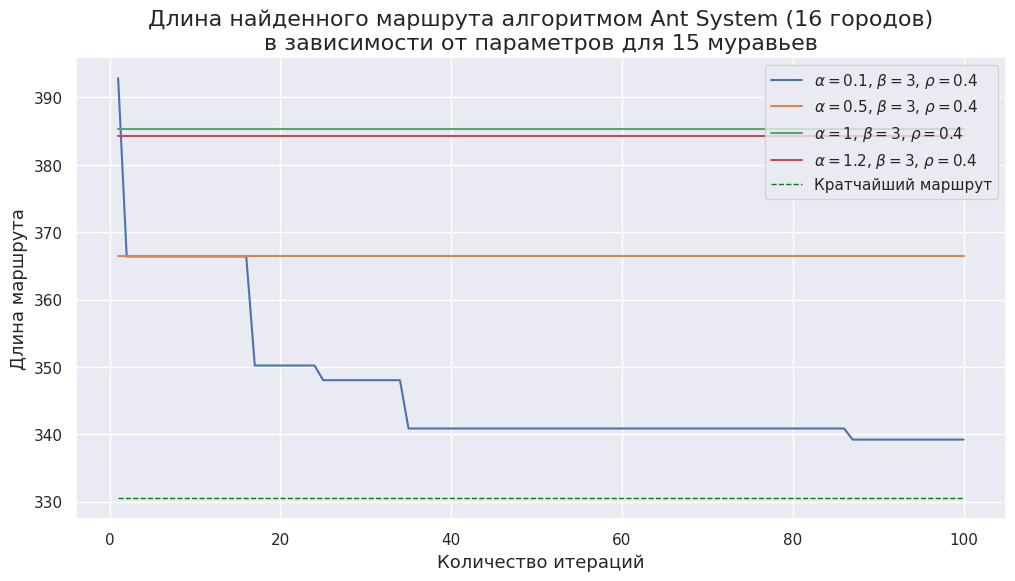

In [36]:
file_path = 'tests/16cities_1.txt'
params = {
    'alpha': [.1, .5, 1, 1.2],
    'beta': [3],
    'rho': [.4]
}

plot_various_params(file_path, 'Ant System (16 городов)', iterations=100, ants=15, 
                    params=params, answer=330.5054664199449)

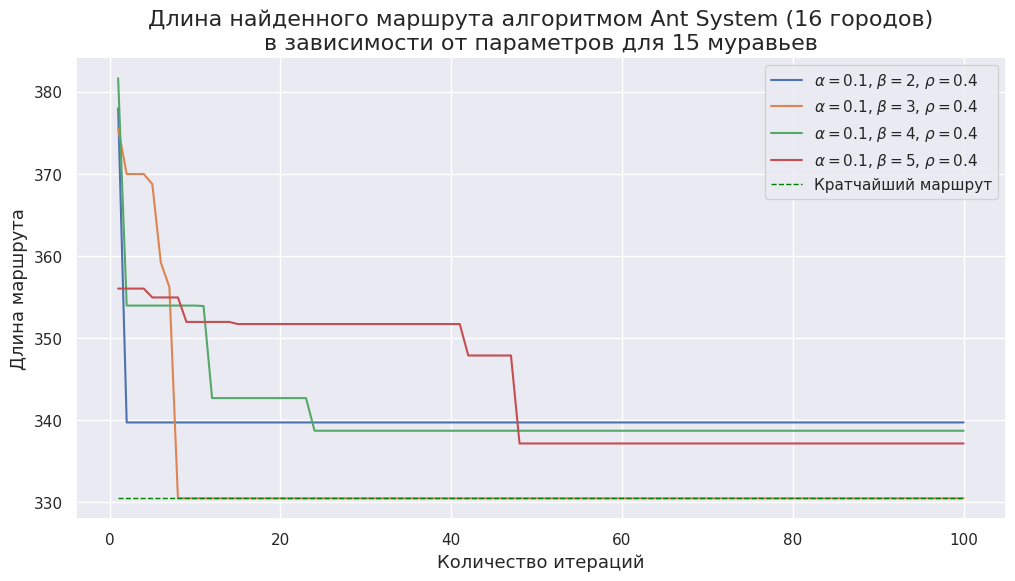

In [37]:
file_path = 'tests/16cities_1.txt'
params = {
    'alpha': [.1],
    'beta': [2, 3, 4, 5],
    'rho': [.4]
}

plot_various_params(file_path, 'Ant System (16 городов)', iterations=100, 
                    ants=15, params=params, answer=330.5054664199449)

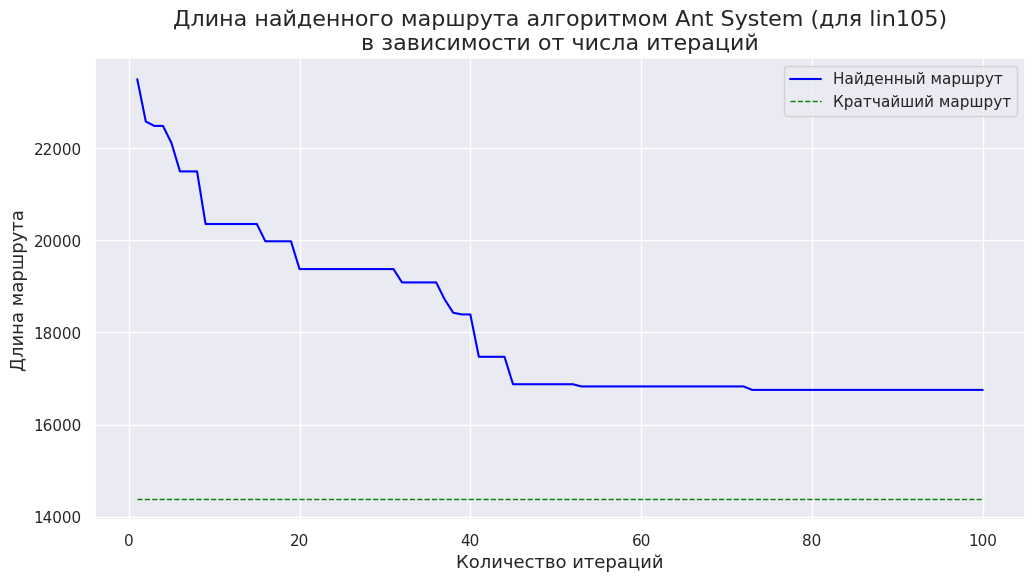

CPU times: user 1h 36min 10s, sys: 15.7 s, total: 1h 36min 26s
Wall time: 1h 36min 33s


In [47]:
%%time
file_path = 'tests/lin105.txt'
iterations = 100
as_settings = AntColony.Settings(alpha=0.5, beta=3, rho=0.5, ants=105, iterations=iterations)
as_colony = AntColony(AntColony.Variation.ANT_SYSTEM, as_settings)

cities_df, tsp = get_solution(file_path, as_colony, attempts=3)
plot_convergence(tsp, 'Ant System (105 городов)', answer=14379)

In [48]:
plot_tsp(cities_df, tsp, 'Ant System')

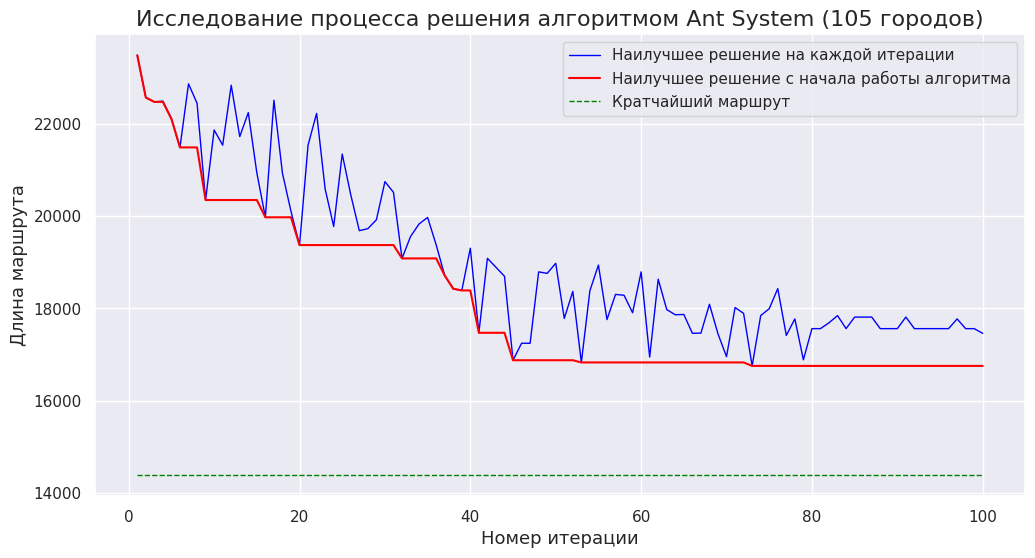

In [50]:
plot_research(tsp, 'Ant System (105 городов)', answer=14379)

In [ ]:
%%time
file_path = 'tests/lin318.txt'
iterations = 400
as_settings = AntColony.Settings(alpha=1, beta=3, rho=0.5, ants=318, iterations=iterations)
as_colony = AntColony(AntColony.Variation.ANT_SYSTEM, as_settings)

cities_df, tsp = get_solution(file_path, as_colony, attempts=1)
plot_convergence(tsp, 'Ant System (318 городов)', answer=42029)

In [54]:
def plot_various_elitist_ants(file_path, title, iterations, ants, elitists, alpha, beta, rho, answer=0):
    plt.figure(figsize=(12, 6))
    grid = np.arange(1, iterations + 1)
    
    for elitist in elitists:
        eas_settings = AntColony.Settings(alpha=alpha, beta=beta, rho=rho, 
                                          ants=ants, elitist=elitist, iterations=iterations)
        eas_colony = AntColony(AntColony.Variation.ELITIST_ANT_SYSTEM, eas_settings)
        cities_df, tsp = get_solution(file_path, eas_colony, 5)
        
        _, distances = tsp.get_solutions_history()
        plt.plot(grid, distances, label=f'{elitist} элитных муравьев')
        
    if answer != 0:
        plt.plot(grid, np.full(iterations, answer), color='green', 
                 linestyle='--', linewidth=1, label='Кратчайший маршрут')
    
    plt.xlabel('Количество итераций', fontsize=13)
    plt.ylabel('Длина маршрута', fontsize=13)
    plt.title(f'Длина найденного маршрута алгоритмом {title}\n' 
              + f'в зависимости от количества элитных муравьев', fontsize=16)
    plt.legend(loc=1)
    
    plt.savefig(get_file_name('elitis_ants_number'))
    plt.show()

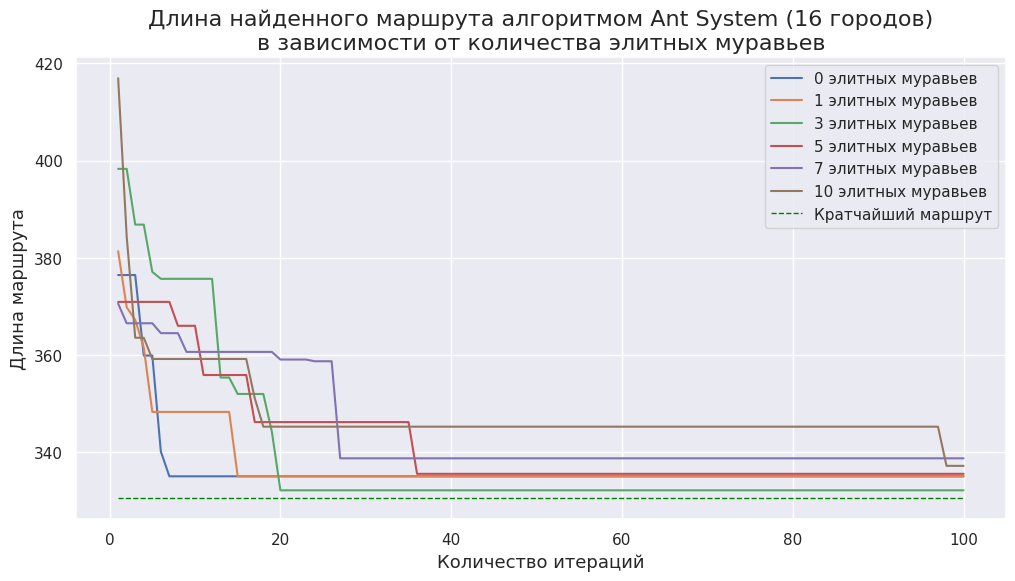

In [55]:
file_path = 'tests/16cities_1.txt'
elitists = [0, 1, 3, 5, 7, 10]

plot_various_elitist_ants(file_path, 'Ant System (16 городов)', iterations=100, ants=15, 
                          elitists=elitists, alpha=.1, beta=3, rho=.4, answer=330.5054664199449)